### Explanation
This code analyse time lapse images of plates with growing colonies and get colony valuable data like size and mean fluorescence over time.

##### Requirements
 - All images have to be same size


## Analysis

### Loading packages

In [1]:
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#we use scikit-image to analyse the images
import skimage 
from skimage import io, filters

### Loading Data

Define the folder name where the images are stored

In [317]:
#note: all the folder used here are ablable in this drive --> https://goo.gl/Trg1DX 

fname =  "D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac\image_%04d.jpg"
#refered to drive folder Lab_27_1_17_pLac


print(fname%(0))   # just to see if names are well defined

D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac\image_0000.jpg


#### Understanding and visualizing the Data

We use PyPlot to read the file into a numpy array (*imread*). This is a 3-dimensional array (a grid of values) with dimensions x,y,c, with (x,y) position and c the color channel (red, green, blue). 

<img src="files/imagearray.png" width=256 height=256>

We can use PyPlot again to display the array (*imshow*), which interprets the array as a color image correctly.

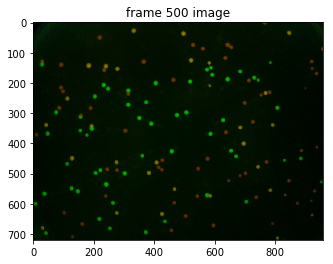

In [35]:
#let's try this with the frame 500 image 

plt.figure()
im1 = plt.imread(fname%500)
plt.imshow(im1)
plt.title('frame '+str(500)+' image')


Or we can show channels separately 

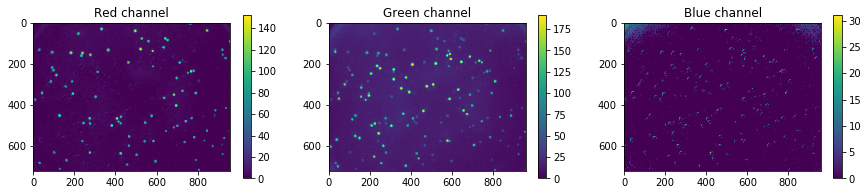

In [37]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(im1[:,:,0])
plt.colorbar()
plt.title('Red channel')

plt.subplot(132)
plt.imshow(im1[:,:,1])
plt.colorbar()
plt.title('Green channel')

plt.subplot(133)
plt.imshow(im1[:,:,2])
plt.colorbar()
plt.title('Blue channel')

Each pixel of each channel can take a value between 0 to 255, which value is indicated accord the colorbar at the side of each plot.


---
#### Taking some data measures
Then, we are interested in get the **size of the image** 

We can get it from the numpy array shape 

The 3rd dimension size is 3 for R,G,B --> We dont need it, so use the "_" variable.

In [5]:
w,h,_ = im1.shape
print('w= '+str(w),'  h= '+str(h))

w= 720   h= 960


#### Loading the time series images
There are 3 channels in each image (R,G,B). 
We will load each channel of all the images into a 3-dimensional array, with dimensions x, y, time. 

<img src="files/timeseriesarray.png" width=256 height=256>

-----
As every image is a timepoint value, we should count the total number of images we have in the folder to know the total timepoints

In [58]:
#define a function to count the images on the folder and import the "glob" library used to do that
import glob
def count_files(path,filetype):
    #inputs: path and filetype (e.g. tif, png, jpg)
    #output: number of defined filetype files on the path folder (integer)
    
    imageCount = len(glob.glob1(path,"*."+filetype))
    print(path.split('\\')[-1]+' = '+str(imageCount) + ' files')
    return(imageCount)

In [61]:
imCount=count_files('D:\Dropbox\FTI\Raspiscope\Time lapse\Lab_27_1_17_pLac',"jpg")

Lab_27_1_17_pLac = 600 files


Also, set the function to read images and save his values on the 3-dimensional array (for each channel)

In [9]:
def get_im_data(xframes,imageCount,fname):
 #inputs:
  #xframes = step frames (e.g. 10 to use only ten to ten images)
  #imageCount = total number of files
  #fname = folder name
  
 #outputs:
   #imsR,imsG,imsB: data per channel of each image (imsR=matrix size (w,h,imagecount/xframes))

    w,h,_ = plt.imread(fname%1).shape      #measure the image size based on the first image on the folder
    nt = int(imageCount/xframes)
    imsR = np.zeros((w,h,nt))
    imsG = np.zeros((w,h,nt))
    imsB = np.zeros((w,h,nt))
    for i in range(0,nt):
        im = plt.imread(fname%(i*xframes))
        imsR[:,:,i] = im[:,:,0]              #last number code the channel: 0=red, 1=green, 2=blue
        imsG[:,:,i] = im[:,:,1]
        imsB[:,:,i] = im[:,:,2]
    return(imsR,imsG,imsB)

# when call you can take only the channels you are interested in (e.g.):
# red,_,blue=get_im_data(xframes,imageCount)  ---> this only takes the red and blue channels

Now we can use this function to read and store the data of the images on a defined array for each channel

In [206]:
DataS={}
Frames=12   # use one image every 12 frames
DataS['R'],DataS['G'],DataS['B']=get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be know from the python timelapse code stored on the folder (named 'interval' on the code).

In [65]:
#define ot on hour units
dT= 1/12  #hours

#in this example interval = 5 min


Whit it, we can construct a **time vector** 'T' for *DataS*

In [125]:
_,_,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i+1)*Frames*dT
    

### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

In [211]:
# get the background time value and plot it

def row_transect(Data, row, frame = -1):    
    #input: 
    # row = the row where you want to see the transect  (integer)
    # frame = image frame to use  (integer), default = last one
    
    plt.figure(figsize=(15,3))
    plt.subplot(131)
    plt.plot(Data['R'][row,:,frame])
    plt.xlabel('pixels')
    plt.ylabel('value')
    plt.title('Red channel')

    plt.subplot(132)
    plt.plot(Data['G'][row,:,frame])
    plt.xlabel('pixels')
    plt.title('Green channel')

    plt.subplot(133)
    plt.plot(Data['B'][row,:,frame])
    plt.xlabel('pixels')
    plt.title('Blue channel')
    
    #plot selected line transect on the image (allways show it on the last frame)
    
    im = plt.imread(Data['Im']%(imCount-1))
    s1,s2,_=im.shape
    plt.figure(figsize=(6,6))
    fig = plt.gcf()
    ax = fig.gca()
    ax.imshow(im)
    rect = matplotlib.patches.Rectangle((0,row),s2,0,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


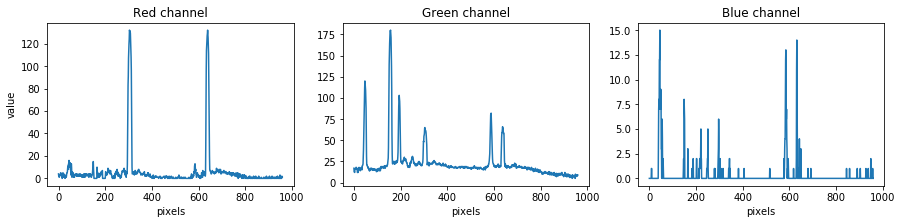

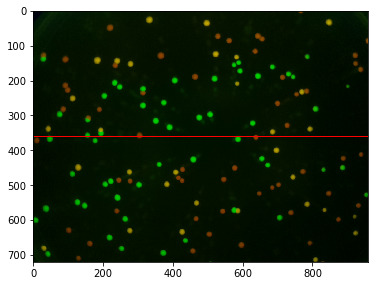

In [212]:
row_transect(DataS,w/2)

As you can see, data show some "picks" (suposed to be colonies) and a basal value along the line (suposed to be agar background signal)

Now, we can select some background sector on the image (i.e. without colonies) and compute his average value on each time step

In [318]:
def BG_Val(X1,X2,Y1,Y2,data):
    #X1,X2,Y1,Y2 --> rectangle area limits: (X1,Y1)--> left-up corner. (X2,Y2) ---> rigth-bottom corner
    #data = the desired channel data to get the background
    
    X2R=X2-X1 #convert on steps because the rectangle patch definition
    Y2R=Y2-Y1
    
    #plot the defined area
    plt.figure(figsize=(8,8))
    fig = plt.gcf()
    ax = fig.gca()
    im = plt.imread(data['Im']%(imCount-1))
    ax.imshow(im)
    rect = matplotlib.patches.Rectangle((Y1,X1),Y2R,X2R,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    
    #get the background time value and plot it
    bg=np.zeros((3,data['R'].shape[2]))
    count=0
    for chan in channels:
        bg[count,:] = data[chan][X1:X2,Y1:Y2,:].mean(axis=(0,1))
        count=count+1
        
    plt.figure()
    plt.plot(bg[0,:],'r')
    plt.hold(True)
    plt.plot(bg[1,:],'g')
    plt.plot(bg[2,:],'b')
    
    plt.xlabel('Time step')
    plt.ylabel('Fluorescence intensity')
        
        
    
    return(bg)

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


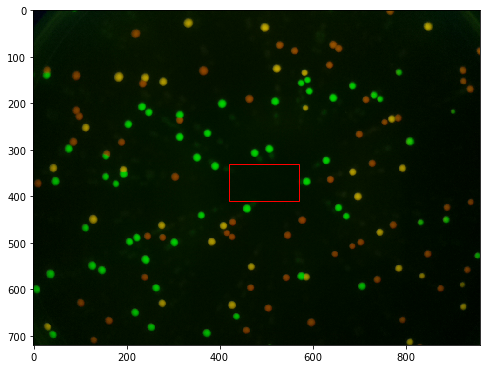

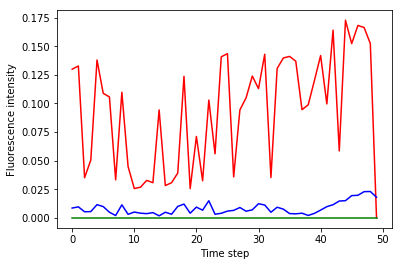

In [320]:
BG=BG_Val(330,410,420,570,DataS)

we can substract that vector value to each frame on the image to eliminate the background effect

To perform it we can define the next function

In [293]:
def BG_subst(Data,bg):
 #inputs
    # Data = image Data
    # bg = Background mean value for each channel and time step
 #return
    # Data = original matrix with the bacground substracted
    
    l=bg.shape[1]
    s1=Data['R'].shape[0]
    s2=Data['R'].shape[1]
    j=0
    for c in channels:
        for i in range(0,l):
            bgm=np.ones((s1,s2))
            bgm= bgm*bg[j,i]         #create a matrix with bg to substract it to the frame
            
            data=Data[c][:,:,i]
            
            data=data-bgm         #perform the substraction
            
            data[data<0]=0        # values < 0 are not allowed --> transform it to 0
            
            Data[c][:,:,i]=data   #actualize Data
        
        j+=1  #to actualize background channel
    
    return(Data)

Then we use the function to obtain the clean data

In [321]:
DataSB=BG_subst(DataS,BG)

and we can check the effect on the background

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


array([[ 0.10463306,  0.10457276,  0.03031641,  0.04658103,  0.10965874,
         0.09356249,  0.09194522,  0.03170094,  0.09386671,  0.03497277,
         0.02483759,  0.02590375,  0.03162702,  0.02941441,  0.08408242,
         0.02715977,  0.02974335,  0.03780631,  0.10153607,  0.02489418,
         0.05719406,  0.02499906,  0.0891752 ,  0.04360308,  0.10850353,
         0.10848111,  0.02899442,  0.08345659,  0.09158886,  0.10140501,
         0.09611991,  0.10461073,  0.03335828,  0.10394504,  0.10503878,
         0.10481049,  0.09413423,  0.08660782,  0.08630144,  0.09458256,
         0.10574669,  0.08912478,  0.12587706,  0.05458227,  0.13595915,
         0.12510725,  0.1210968 ,  0.14034342,  0.13281754,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

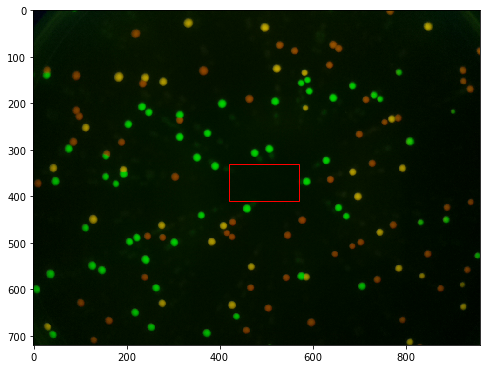

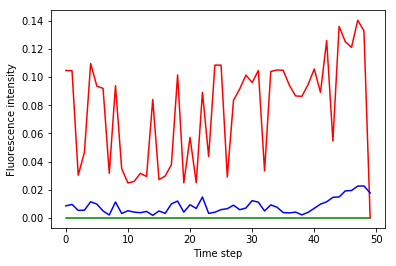

In [322]:
BG_Val(330,410,420,570,DataSB)

Background was practically eliminated

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

In [326]:
def dataOT(Data):
   
    plt.imshow(Data['R'][:,:,:].sum(axis=(2))+Data['G'][:,:,:].sum(axis=(2))+Data['B'][:,:,:].sum(axis=(2)))
    plt.colorbar()
    plt.title('channel')


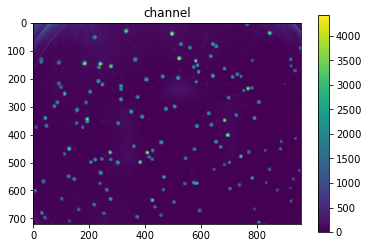

In [330]:
dataOT(DataSB)

Now we can see each colony as a more clear point

To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data:

In [331]:
# skimage have a usefull gaussian filter for this task
from skimage.filters import gaussian

In [ ]:
def dataOT(Data):

    plt.figure(figsize=(17,3))
    pvect = [131,132,133]
    count=0
    for c in channels:
    
        plt.subplot(pvect[count])
        plt.imshow(Data[c][:,:,:].sum(axis=(2)))
        plt.colorbar()
        plt.title(c+' channel')
    
        count+=1